# Piping a Prompt, Model and Output Parser

In [46]:
import dotenv

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import CommaSeparatedListOutputParser, StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda, chain

from IPython.display import Image, display

dotenv.load_dotenv()

True

In [3]:
list_instructions = CommaSeparatedListOutputParser().get_format_instructions()

In [4]:
list_instructions 

'Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`'

In [19]:
chat_template = ChatPromptTemplate.from_messages([
    ('human', "I've recently adopted a {pet_type}. Can you recommend three {pet_type} names? \n" + list_instructions)
])

In [20]:
print(chat_template.messages[0].prompt.template)

I've recently adopted a {pet_type}. Can you recommend three {pet_type} names? 
Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`


In [18]:
chat = ChatOpenAI(
    model="gpt-4", 
    seed=365, 
    temperature=0, 
    max_tokens=500)

In [22]:
list_output_parser = CommaSeparatedListOutputParser()

In [23]:
chat_template_result = chat_template.invoke({"pet_type": "dog"})

In [24]:
chat_result = chat.invoke(chat_template_result)

In [26]:
print(chat_result.content)

Max, Bella, Charlie


In [27]:
list_output_parser.invoke(chat_result.content)

['Max', 'Bella', 'Charlie']

In [28]:
# Using LCEL to chain the prompt, model and output parser

chain = chat_template | chat | list_output_parser

In [29]:
chain_result = chain.invoke({"pet_type": "dog"})
print(chain_result)

['Max', 'Bella', 'Charlie']


# Batching

In [31]:
chat_template_batch = chat_template.from_messages([
    ('human', 
    'I\'ve recently adopted a {pet_type} which is a {breed}. Could you suggest some training tips?')
])

In [5]:
chat = ChatOpenAI(
    model="gpt-4", 
    seed=365, 
    temperature=0, 
    max_tokens=100)

In [34]:
chain_batch = chat_template_batch | chat

In [ ]:
# Batching - runs the invoke() method on each item in the list in parallel, recuding time. 

chain_batch_result = chain_batch.batch([
    {"pet_type": "dog", "breed": "Labrador"},
    {"pet_type": "cat", "breed": "Persian"},
    {"pet_type": "dragon", "breed": "night fury"}
])


In [36]:
chain_batch_result

[AIMessage(content='Absolutely, training a Labrador can be a rewarding experience. Here are some tips:\n\n1. Start Early: The earlier you start training your Labrador, the better. They are quick learners and starting early can help them adapt to the rules of your house.\n\n2. Consistency is Key: Be consistent with your commands. If you use different commands for the same action, it can confuse your dog. \n\n3. Positive Reinforcement: Always reward your dog for good behavior. This can be in the form', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 25, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-D7jCJ9s7UWMMA0B7sZkuSi8Ia95ff', 'service_tier': 

In [42]:
for result in chain_batch_result:
    print(f'{result.content}' + '\n' + '='*100 + '\n')

Absolutely, training a Labrador can be a rewarding experience. Here are some tips:

1. Start Early: The earlier you start training your Labrador, the better. They are quick learners and starting early can help them adapt to the rules of your house.

2. Consistency is Key: Be consistent with your commands. If you use different commands for the same action, it can confuse your dog. 

3. Positive Reinforcement: Always reward your dog for good behavior. This can be in the form

Training a Persian cat can be a rewarding experience, as they are known for their gentle and calm temperament. Here are some tips:

1. Start Early: The earlier you start training your Persian cat, the better. They are more likely to adapt to new behaviors when they are young.

2. Use Positive Reinforcement: Always use positive reinforcement when training your cat. This means rewarding them with treats, praise, or petting when they do something right. Never punish your cat as it can lead to

Training a dragon, especi

# Stream

In [43]:
stream = chain_batch.stream({"pet_type": "dragon", "breed": "night fury"})

In [44]:
stream

<generator object RunnableSequence.stream at 0x11516c200>

In [46]:
next(stream)

AIMessageChunk(content='Training', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--019c4807-fb6d-7502-bbdc-13a0d4fc9ecc', tool_calls=[], invalid_tool_calls=[], tool_call_chunks=[])

In [47]:
for i in stream:
    print(i.content, end='')

 a dragon, especially a Night Fury, is no small task. Here are some tips to help you:

1. Establish Trust: Night Furies are intelligent and sensitive creatures. They need to trust you before they can be trained. Spend time with your dragon, talk to it, and show it that you mean no harm.

2. Positive Reinforcement: Like any other pet, dragons respond well to positive reinforcement. Reward your dragon with treats or affection when it behaves well. This will encourage it

# Runnable and Runnable Sequence classes

In [48]:
type(chain)

langchain_core.runnables.base.RunnableSequence

In [50]:
RunnablePassthrough().invoke("Hello, world!")

'Hello, world!'

In [51]:
RunnablePassthrough().invoke([1, 2, 3])

[1, 2, 3]

In [54]:
chat_template_tools = ChatPromptTemplate.from_template(
    """ What are the most important tools for {job_title}
    Answer by only listing the tools, no other text.
    """
)

In [55]:
chat_template_tools

ChatPromptTemplate(input_variables=['job_title'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['job_title'], input_types={}, partial_variables={}, template=' What are the most important tools for {job_title}\n    Answer by only listing the tools, no other text.\n    '), additional_kwargs={})])

In [56]:
chat_template_tools_strategy = ChatPromptTemplate.from_template(
    """ Considering the tools provided, develop a strategy for effectively learning
    and mastering them: {tools}
    """)

In [57]:
chat_template_tools_strategy

ChatPromptTemplate(input_variables=['tools'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['tools'], input_types={}, partial_variables={}, template=' Considering the tools provided, develop a strategy for effectively learning\n    and mastering them: {tools}\n    '), additional_kwargs={})])

In [6]:
string_parser = StrOutputParser()

In [ ]:
chain_tools = chat_template_tools | chat | string_parser | {'tools': RunnablePassthrough()}
chain_strategy = chat_template_tools_strategy | chat | string_parser
chain_combined = chain_tools | chain_strategy

# RunnablePassThrough in the 'chain_tools' is needed to convert the string output into a dictionary. 
# This is because the 'chain_strategy' expects a dictionary input.

In [64]:
print(chain_combined.invoke({"job_title": "data scientist"}))

1. Python: Start with basics like syntax, data types, loops, and functions. Then move on to more advanced topics like classes and file I/O. Use online resources like Codecademy, Coursera, and Python's official documentation. Practice by building small projects.

2. R: Start with basics like vectors, matrices, lists, and data frames. Then move on to more advanced topics like loops, functions, and packages. Use online resources like DataCamp, Coursera,


# Graphing Runnables 

In [65]:
chain_long = (
    chat_template_tools | chat | string_parser | {'tools': RunnablePassthrough()} |
    chat_template_tools_strategy | chat | string_parser
)

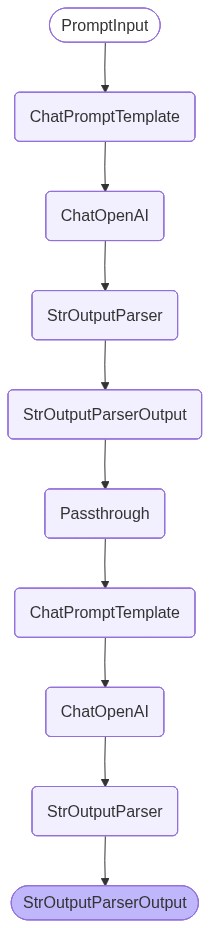

In [70]:
display(Image(data=(chain_combined.get_graph().draw_mermaid_png())))

# Runnable Paralell 

In [17]:
chat_template_books = ChatPromptTemplate.from_template(
    """ Recommend three books on intermediate-level {programming_language}.
    Answer by only listing the books, no other text.
    """
    )

chat_template_projects = ChatPromptTemplate.from_template(
    """ Suggest three interesting {programming_language} projects that are suitable
    for intermediate-level programmers.
    Answer by only listing the projects, no other text.
    """
    )

chat_template_time = ChatPromptTemplate.from_template(
    """ I am an intermediate-level programmer.

    Consider the following literature:
    {books}

    Consider the following projects:
    {projects}

    Roughly how long would it take me to complete the literature and projects?
    """
)

In [7]:
chain_books = chat_template_books | chat | string_parser
chain_projects = chat_template_projects | chat | string_parser


In [8]:
chain_parallel = RunnableParallel({'books': chain_books, 'projects': chain_projects})

In [9]:
chain_parallel.invoke({"programming_language": "python"})

{'books': '1. "Python Crash Course: A Hands-On, Project-Based Introduction to Programming" by Eric Matthes\n2. "Fluent Python: Clear, Concise, and Effective Programming" by Luciano Ramalho\n3. "Effective Python: 90 Specific Ways to Write Better Python" by Brett Slatkin',
 'projects': '1. Building a Weather Forecasting Application using APIs.\n2. Developing a Personal Finance Tracker with GUI.\n3. Creating a Web Scraper for E-commerce Websites.'}

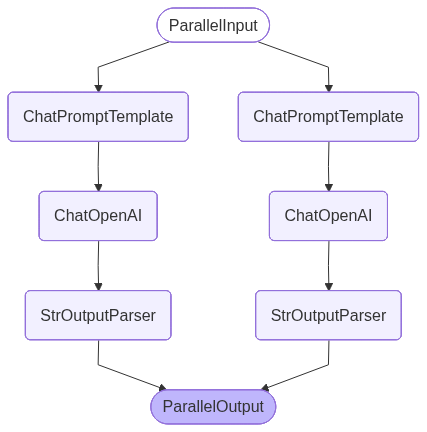

In [10]:
display(Image(data=(chain_parallel.get_graph().draw_mermaid_png())))

In [13]:
print(chain_parallel.get_graph().draw_ascii())

            +-------------------------------+              
            | Parallel<books,projects>Input |              
            +-------------------------------+              
                   ***               ***                   
                ***                     ***                
              **                           **              
+--------------------+              +--------------------+ 
| ChatPromptTemplate |              | ChatPromptTemplate | 
+--------------------+              +--------------------+ 
           *                                   *           
           *                                   *           
           *                                   *           
    +------------+                      +------------+     
    | ChatOpenAI |                      | ChatOpenAI |     
    +------------+                      +------------+     
           *                                   *           
           *                            

In [14]:
%%time
chain_books.invoke({"programming_language": "python"})

CPU times: user 8.91 ms, sys: 2.68 ms, total: 11.6 ms
Wall time: 3.32 s


'1. "Python Crash Course: A Hands-On, Project-Based Introduction to Programming" by Eric Matthes\n2. "Fluent Python: Clear, Concise, and Effective Programming" by Luciano Ramalho\n3. "Effective Python: 90 Specific Ways to Write Better Python" by Brett Slatkin'

In [15]:
%%time
chain_projects.invoke({"programming_language": "python"})

CPU times: user 5.48 ms, sys: 1.27 ms, total: 6.75 ms
Wall time: 3.06 s


'1. Building a Web Scraper using BeautifulSoup.\n2. Developing a simple Machine Learning model using Scikit-learn.\n3. Creating a GUI application with Tkinter.'

In [16]:
%%time
chain_parallel.invoke({"programming_language": "python"})

CPU times: user 13.9 ms, sys: 2.84 ms, total: 16.7 ms
Wall time: 2.17 s


{'books': '1. "Python Crash Course: A Hands-On, Project-Based Introduction to Programming" by Eric Matthes\n2. "Fluent Python: Clear, Concise, and Effective Programming" by Luciano Ramalho\n3. "Effective Python: 90 Specific Ways to Write Better Python" by Brett Slatkin',
 'projects': '1. Building a Web Scraper using BeautifulSoup.\n2. Developing a simple GUI-based Desktop Application using Tkinter.\n3. Creating a Text-based Adventure Game using Object-Oriented Programming.'}

# Chaining RunnableParallel with other runnables

In [21]:
chain_time = (RunnableParallel(
    {'books': chain_books, 
    'projects': chain_projects}) 
    | chat_template_time 
    | chat
    | string_parser
)

In [22]:
print(chain_time.invoke({"programming_language": "python"}))

The time it takes to complete the literature and projects can vary greatly depending on several factors such as your current skill level, the amount of time you can dedicate each day, your learning pace, and your familiarity with the topics covered. 

However, here's a rough estimate:

1. "Python Crash Course: A Hands-On, Project-Based Introduction to Programming" by Eric Matthes: This book is around 550 pages. If you read and practice for about 2 hours a day, it might take you around 4-6 weeks to complete.

2. "Fluent Python: Clear, Concise, and Effective Programming" by Luciano Ramalho: This book is more advanced and is around 770 pages. It might take you around 6-8 weeks to complete at the same pace.

3. "Effective Python: 90 Specific Ways to Write Better Python" by Brett Slatkin: This book is around 230 pages and is quite practical. It might take you around 2-3 weeks to complete.

For the projects:

1. Building a Web Scraper using BeautifulSoup: If you're already familiar with the 

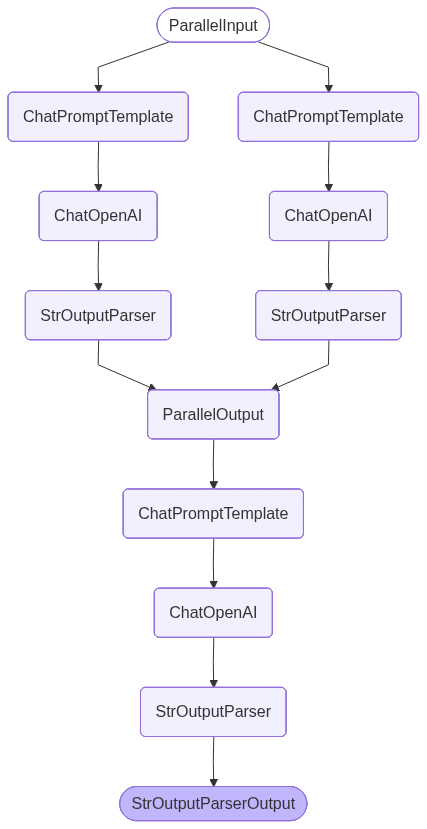

In [23]:
display(Image(data=(chain_time.get_graph().draw_mermaid_png())))

In [27]:
print(chain_time.get_graph().draw_ascii())


            +-------------------------------+              
            | Parallel<books,projects>Input |              
            +-------------------------------+              
                   ***               ***                   
                ***                     ***                
              **                           **              
+--------------------+              +--------------------+ 
| ChatPromptTemplate |              | ChatPromptTemplate | 
+--------------------+              +--------------------+ 
           *                                   *           
           *                                   *           
           *                                   *           
    +------------+                      +------------+     
    | ChatOpenAI |                      | ChatOpenAI |     
    +------------+                      +------------+     
           *                                   *           
           *                            

# RunnableLambda

In [28]:
find_sum = lambda x: sum(x)


In [30]:
find_sum([1, 2, 5])

8

In [31]:
find_square = lambda x: x**2

In [32]:
find_square(8)


64

In [34]:
runnable_sum = RunnableLambda(lambda x: sum(x))

In [35]:
runnable_square = RunnableLambda(lambda x: x**2)

In [36]:
runnable_lambda_chain = runnable_sum | runnable_square

In [38]:
runnable_lambda_chain.invoke([1, 2, 5])

64

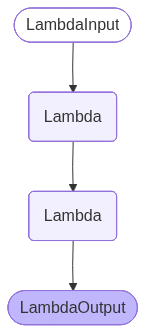

In [41]:
display(Image(data=(runnable_lambda_chain.get_graph().draw_mermaid_png())))





In [42]:
print(runnable_lambda_chain.get_graph().draw_ascii())

+-------------+  
| LambdaInput |  
+-------------+  
        *        
        *        
        *        
   +--------+    
   | Lambda |    
   +--------+    
        *        
        *        
        *        
   +--------+    
   | Lambda |    
   +--------+    
        *        
        *        
        *        
+--------------+ 
| LambdaOutput | 
+--------------+ 


# The @chain Decorator

In [43]:
def find_sum(x):
    return sum(x)

def find_square(x):
    return x**2



In [44]:
chain1 = RunnableLambda(find_sum) | RunnableLambda(find_square)
chain1.invoke([1, 2, 5])

64

In [59]:
@chain #Decorator that wraps the function in a RunnableLambda
def runnable_sum(x):
    return sum(x)

@chain
def runnable_square(x):
    return x**2

In [57]:
type(runnable_sum) 

langchain_core.runnables.base.RunnableLambda

In [58]:
type(runnable_square)


langchain_core.runnables.base.RunnableLambda

In [60]:
chain2 = runnable_sum | runnable_square
chain2.invoke([1, 2, 5])





64